In [ ]:
# dripyto# install basical image libs
!pip install Pillow>=5.0.0
!pip install -U image
!pip install wheel

# install torch and torchvision (a utility library for computer vision that provides many public datasets and pre-trained models)
!pip install torch torchvision

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
cuda0 = torch.device('cuda:0')  if torch.cuda.is_available() else torch.device('cpu')

import torchvision
import torchsummary

import PIL
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cuda0

device(type='cuda', index=0)

In [3]:
# Utility functions
def tensor2image(tensor):
    return PIL.Image.fromarray((tensor.detach() * 127.5 + 128).clamp_(0, 255).to('cpu', torch.uint8).numpy()[0])

def display_tensor(tensor):
    plt.figure(figsize=(5,5))
    plt.imshow(tensor2image(tensor), cmap='gray')
    plt.axis('off')
    plt.show()

def display_label(label):
    plt.figure(figsize=(6, 5))
    sns.heatmap(tensor2image(label))
    plt.axis('off')
    plt.show()

def crop_nearest_2_power(power_2, image):
    H, W = image.shape[-2:]
    new_H = H  - (H % 2 ** power_2)
    new_W = W  - (W % 2 ** power_2)
    return torchvision.transforms.CenterCrop((new_H, new_W))(image)

In [4]:
# load VOCSegmentation dataset
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5,), std=(0.5,)),
])

class times255(object):
    def __call__(self, image):
        return image * 255

class binzarize_label(object):
    def __call__(self, image):
        return torch.where(image > 0, 1, 0)

target_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    times255(),
    binzarize_label(),
])

train_set = VOCSegmentation('data/VOC', year='2007', image_set='train', download=True, transform=transform,
                            target_transform=target_transform)

val_set = VOCSegmentation('data/VOC', year='2007', image_set='val', download=True, transform=transform,
                            target_transform=target_transform)


# keep the batch size equal to 1 here because the images have different sizes
# not shuffling the validation set allows testing on a fixed subset
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)


100%|██████████| 460M/460M [00:17<00:00, 25.7MB/s]


Extracting data/VOC/VOCtrainval_06-Nov-2007.tar to data/VOC
Using downloaded and verified file: data/VOC/VOCtrainval_06-Nov-2007.tar
Extracting data/VOC/VOCtrainval_06-Nov-2007.tar to data/VOC


torch.Size([3, 370, 500])
torch.Size([1, 370, 500])
tensor(1)
tensor(0)
tensor([0, 1])


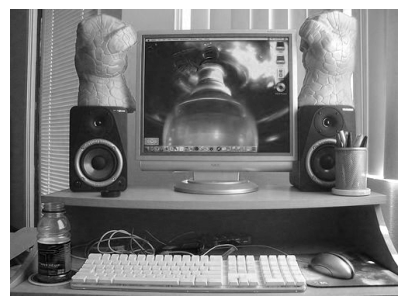

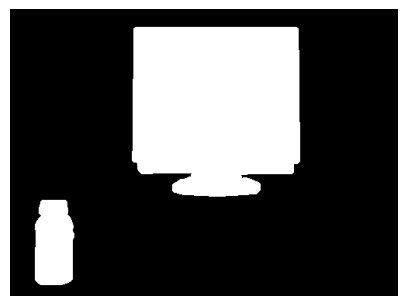

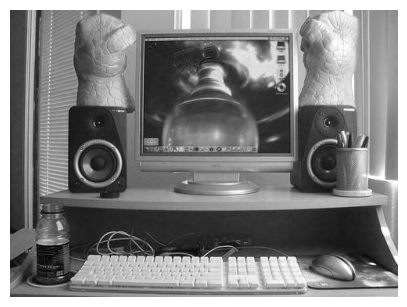

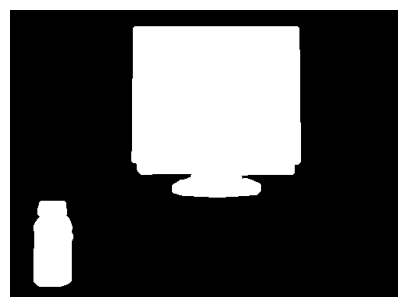

In [5]:
# Simple tests and visualizations
# print(train_set)

train0 = train_set[10]

print(train0[0].shape)
print(train0[1].shape)

print(train0[1].max())
print(train0[1].min())
print(torch.unique(train0[1])) # finds all the unique labels in given segmentation image

display_tensor(train0[0])
display_tensor(train0[1])

# display cropped images
display_tensor(crop_nearest_2_power(3, train0[0]))
display_tensor(crop_nearest_2_power(3, train0[1]))

In [6]:
# Define a simple model
# This will NOT be sufficient, but can get you started
# You should at least two more layers to receive partial credit

class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = torch.nn.Conv2d(64, 2, 3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x)
        return x

In [7]:
# TODO: network specification goes here

class Conv1(nn.Module):
    def __init__(self, in_channels, c):
        super(Conv1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, c, 3, padding=1)
        self.conv2 = nn.Conv2d(c, c, 3, padding=1)

    def forward(self, img):
        self.layer1 = F.relu(self.conv1(img))
        self.layer2 = F.relu(self.conv2(self.layer1))
        return self.layer2

class Conv2(nn.Module):
    def __init__(self, in_channels, c):
        super(Conv2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, c, 5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(c, c, 3, padding=1)
        self.conv3 = nn.Conv2d(c, c, 3, padding=1)

    def forward(self, img):
        self.layer1 = F.relu(self.conv1(img))
        self.layer2 = F.relu(self.conv2(self.layer1))
        self.layer3 = F.relu(self.conv3(self.layer2))
        return self.layer3

class Conv3(nn.Module):
    def __init__(self, in_channels, c):
        super(Conv3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, c, 5, padding=2, stride=2)
        self.conv2 = nn.Conv2d(c, c, 3, padding=1)
        self.conv3 = nn.Conv2d(c, c, 3, padding=1)

    def forward(self, img):
        self.layer1 = F.relu(self.conv1(img))
        self.layer2 = F.relu(self.conv2(self.layer1))
        self.layer3 = F.relu(self.conv3(self.layer2))
        return self.layer3


class BasicUNet(nn.Module):
    def __init__(self, in_channels, c, out_channels):
        super(BasicUNet, self).__init__()
        self.conv_encoder_1 = Conv1(in_channels, c)
        self.conv_encoder_2 = Conv2(c, c * 2)
        self.conv_encoder_3 = Conv3(c * 2, c * 4)

        # decoding layers
        self.conv_decoder_1 = nn.Conv2d(c * 2, c * 4, 3, padding=1)
        self.conv_decoder_2 = nn.Conv2d(c * 4, c * 2, 1, padding=0)
        self.conv_decoder_3 = nn.Conv2d(c, c * 2, 1, padding=0)
        self.conv_decoder_4 = nn.Conv2d(c * 2, out_channels, 1, padding=0)



    def forward(self, img):
        # econding layers
        conv_encoding_1 = self.conv_encoder_1(img)
        conv_encoding_2 = self.conv_encoder_2(conv_encoding_1)
        conv_encoding_3 = self.conv_encoder_3(conv_encoding_2)

        # decoding layers
        upsampled_1 = F.interpolate(conv_encoding_3, scale_factor=2, mode='bilinear', align_corners=True)
        conv_decoding_1 = F.relu(self.conv_decoder_1(conv_encoding_2))
        conv_decoding_2 = F.relu(self.conv_decoder_2(conv_decoding_1 + upsampled_1))

        upsampled_2 = F.interpolate(conv_decoding_2, scale_factor=2, mode='bilinear', align_corners=True)
        conv_decoding_3 = F.relu(self.conv_decoder_3(conv_encoding_1))
        conv_decoding_4 = self.conv_decoder_4(conv_decoding_3 + upsampled_2)
        return conv_decoding_4



In [8]:
# TODO: create instance of network
# include init parameters
net = BasicUNet(3, 64, 2).to(cuda0)


In [9]:
# This network outputs 2 logits per pixel, as verified below
# using a random input tensor.
# IT IS VERY IMPORTANT THAT YOUR NETWORK PASSES THIS TEST
# There should be 3 input channels (RGB).
# TODO: These image dimensions will work, but try different ones as well

random_input = torch.randn(4, 3, 200, 160, device=cuda0)
output = net(random_input)
print(output.shape)

torchsummary.summary(net, (3, 200, 160))

torch.Size([4, 2, 200, 160])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 160]           1,792
            Conv2d-2         [-1, 64, 200, 160]          36,928
             Conv1-3         [-1, 64, 200, 160]               0
            Conv2d-4         [-1, 128, 100, 80]         204,928
            Conv2d-5         [-1, 128, 100, 80]         147,584
            Conv2d-6         [-1, 128, 100, 80]         147,584
             Conv2-7         [-1, 128, 100, 80]               0
            Conv2d-8          [-1, 256, 50, 40]         819,456
            Conv2d-9          [-1, 256, 50, 40]         590,080
           Conv2d-10          [-1, 256, 50, 40]         590,080
            Conv3-11          [-1, 256, 50, 40]               0
           Conv2d-12         [-1, 256, 100, 80]         295,168
           Conv2d-13         [-1, 128, 100, 80]          32,896
          

In [10]:
# Training loop
def train(net, optim, crit):
    net.train()
    for image_cpu, labels_cpu in train_loader:
        # TODO: convert labels to 0 and 1 - done as transform while loading data

        # TODO: adjust image width and height for UNet to work
        image_cpu = crop_nearest_2_power(3, image_cpu)
        labels_cpu = crop_nearest_2_power(3, labels_cpu)

        # put data onto GPU
        image = image_cpu.to(cuda0)
        labels = labels_cpu.to(cuda0)

        # clear gradient
        optim.zero_grad()

        # forward through the network
        output = net(image)

        labels = labels.flatten(start_dim=2)
        output = output.flatten(start_dim=2)
        labels.squeeze_(dim=0)

        # compute loss and gradient
        loss = crit(output, labels.long())
        loss.backward()

        # update parameters
        optim.step()

In [21]:
# Evaluation on validation set
def evaluate(net):
    total = 0
    correct = 0
    # TODO: add other statistics to be tracked

    net.eval()  # puts the network in eval mode. this is important when the
                # network has layers that behave differently in training and
                # evaluation time, e.g., dropout and batch norm.
    i = 0
    for image_cpu, labels_cpu in val_loader:
        # TODO: convert labels to 0 and 1

        # TODO: adjust image width and height for UNet to work
        image_cpu = crop_nearest_2_power(3, image_cpu)
        labels_cpu = crop_nearest_2_power(3, labels_cpu)

        # put data onto GPU
        image = image_cpu.to(cuda0)
        labels = labels_cpu.to(cuda0)
        labels.squeeze_(dim=0)

        with torch.no_grad():  # gradients are not tracked in this context manager
                               # since we are evaluating, gradients are not needed
                               # and we can save some time and GPU memory.

            # forward through the network, and get the predicted class
            prediction = net(image).argmax(dim=1)

            total += prediction.shape[1]*prediction.shape[2]
            correct += (prediction == labels).sum().item()  # `.item()` retreives a python number from a 1-element tensor


        # early abort for development
        # i = i+1
        # #print('correct ' + str(correct) + ' total ' + str(total))
        # if i >= 10:
        #     break

    return correct / total

def confusion_matrix(net):
    net.eval()
    tp, fp, tn, fn = 0, 0, 0, 0
    total = 0
    for image_cpu, labels_cpu in val_loader:
        image_cpu = crop_nearest_2_power(3, image_cpu)
        labels_cpu = crop_nearest_2_power(3, labels_cpu)

        # put data onto GPU
        image = image_cpu.to(cuda0)
        labels = labels_cpu.to(cuda0)
        labels.squeeze_(dim=0)

        with torch.no_grad():  # gradients are not tracked in this context manager
                               # since we are evaluating, gradients are not needed
                               # and we can save some time and GPU memory.

            # forward through the network, and get the predicted class
            prediction = net(image).argmax(dim=1)
            total += prediction.shape[1]*prediction.shape[2]

            tp += ((prediction == 1) & (labels == 1)).sum().item()
            fp += ((prediction == 1) & (labels == 0)).sum().item()
            tn += ((prediction == 0) & (labels == 0)).sum().item()
            fn += ((prediction == 0) & (labels == 1)).sum().item()

    return np.array([[tn, fn], [fp, tp]])

In [12]:
# main
# TODO: adjust number of epochs
num_epochs = 10

lr = 0.0005

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

for epoch in range(num_epochs):
    print('Epoch: {}\tValidation Accuracy: {:.4f}%'.format(epoch, evaluate(net) * 100))
    train(net, optimizer, criterion)

print('Done! \tValidation Accuracy: {:.4f}%'.format(evaluate(net) * 100))

Epoch: 0	Validation Accuracy: 30.1799%
Epoch: 1	Validation Accuracy: 69.8201%
Epoch: 2	Validation Accuracy: 70.1372%
Epoch: 3	Validation Accuracy: 70.1911%
Epoch: 4	Validation Accuracy: 70.1966%
Epoch: 5	Validation Accuracy: 70.3947%
Epoch: 6	Validation Accuracy: 70.4621%
Epoch: 7	Validation Accuracy: 68.8398%
Epoch: 8	Validation Accuracy: 70.7422%
Epoch: 9	Validation Accuracy: 70.5546%
Done! 	Validation Accuracy: 70.9007%


In [13]:
model_path = 'model.pth'
torch.save(net.state_dict(), model_path)

In [14]:
model_path = 'model.pth'
net_state = torch.load(model_path, map_location=cuda0)

net = BasicUNet(3, 64, 2).to(cuda0)
net.load_state_dict(net_state)

<ipython-input-14-bdfc0abe47b1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net_state = torch.load(model_path, map_location=cuda0)


<All keys matched successfully>

In [ ]:
cm = confusion_matrix(net)

Text(50.722222222222214, 0.5, 'Predicted')

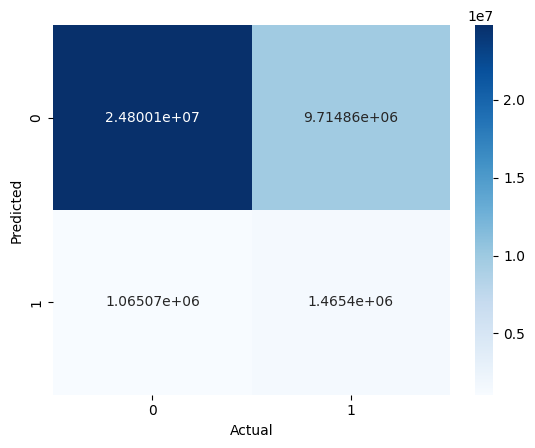

In [36]:
sns.heatmap(cm, cmap='Blues', annot=True, fmt='g', yticklabels=[0, 1], xticklabels=[0, 1])
plt.xlabel('Actual')
plt.ylabel('Predicted')

Text(50.722222222222214, 0.5, 'Predicted')

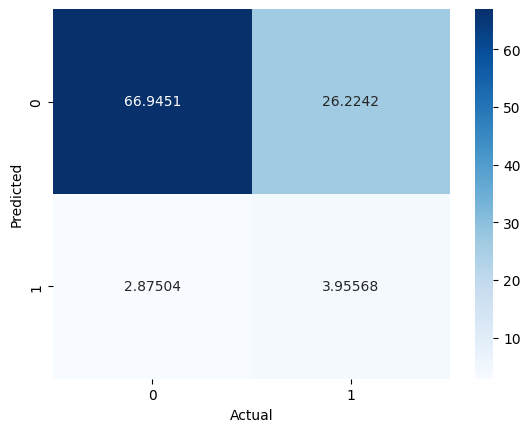

In [35]:
sns.heatmap(cm / cm.sum() * 100, cmap='Blues', annot=True, fmt='g', yticklabels=[0, 1], xticklabels=[0, 1])
plt.xlabel('Actual')
plt.ylabel('Predicted')

In [41]:
tn, fn, fp, tp = cm.ravel()
precision = tp / (tp + fp)
precision_background = tn / (tn + fn)
recall = tp / (tp + fn)
recall_background = tn / (tn + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
print("Accuracy: ", accuracy * 100)
print("Precision (label 1): ", precision * 100)
print("Recall (label 1): ", recall * 100)
print("Precision (label 0): ", precision_background * 100)
print("Recall (label 0)", recall_background * 100)

Accuracy:  70.90074885459389
Precision (label 1):  57.910157330580745
Recall (label 1):  13.107017684301475
Precision (label 0):  71.85315690251876
Recall (label 0) 95.88221528134355
